<a href="https://colab.research.google.com/github/Yarrieta/PROBABILIDAD_Y_ESTADISTICA_IA/blob/examen_final/hypothesis_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen final Probabilidad y Estadística para Inteligencia Artificial

Siguiendo con la historia de Don Francisco, con el tiempo y gracias a los análisis de Matı́as, el pequeño comerciante de
barrio cuenta hoy con 5 supermercados: ’Santa Ana’, ’La Floresta’, ’Los Cedros’, ’Palermo’ y ’Córdoba’.
También Matı́as ha avanzado en la Especialización en Inteligencia Artificial. Un dı́a Don Francisco le plantea algunas
inquietudes adicionales:
1. Don Francisco quiere entender mejor las ventas por mes del supermercado ’Santa Ana’.
2. Más aún, Don Francisco no sabe si puede estar seguro de que las ventas son las mismas en todos los supermercados o si
hay alguno que se comporte mejor que los demás, y si alguna de las tiendas necesita más atención porque sus ventas sean
peores que las de las otras.
3. Don Francisco tiene 5 clientes a los que les ha vendido mercancı́as a crédito y, de ellos, 1 están en mora con el pago prometido.
Matı́as, teniendo en cuenta la información disponible, considera que puede modelar el porcentaje p de morosidad según una
distribución B(1, 2). Para determinar los parámetros α y β, decide usar inferencia bayesiana. Con esto, pretende explicarle
a Don Francisco, cómo será el comportamiento de pago de sus clientes a crédito.

In [101]:
#Librerias importadas
from google.colab import drive
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Análisis exploratorio

In [117]:
# cargar datos de los 5 supermercados para ver los periodos de las fechas de los registros
drive.mount('/content/drive')

data_dict = {
    "Santa Ana": "/content/drive/MyDrive/examen-final-PEIA/Datos_examen_final_17Co2024_Grupo9.xlsx - Santa Ana.csv",
    "Cordoba": "/content/drive/MyDrive/examen-final-PEIA/supermercado_cordoba.xlsx - corboda.csv",
    "La Floresta": "/content/drive/MyDrive/examen-final-PEIA/supermercado_la_floresta.xlsx - la_floresta.csv",
    "Los Cedros": "/content/drive/MyDrive/examen-final-PEIA/supermercado_los_cedros.xlsx - los_cedros.csv",
    "Palermo": "/content/drive/MyDrive/examen-final-PEIA/supermercado_cordoba.xlsx - corboda.csv"
}

df_lst_year = []
for name, path in data_dict.items():
    try:
        df = pd.read_csv(path) # Try reading the file
        if name != "Santa Ana":
            df["Ventas"] = pd.to_numeric(df["Ventas"].str.replace(",", "."))
            df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y")
        else:
            df["Fecha"] = pd.to_datetime(df["Fecha"], format="%m/%d/%Y")
        df.rename(columns={"Ventas": "Ventas " + name}, inplace=True)
        #df.set_index("Fecha", inplace=True)
        df_lst_year.append(df)
    except FileNotFoundError:
        print(f"File not found: {path}") # Print an error message if the file is not found

data_year = pd.concat(df_lst_year, axis=1)
data_year.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Fecha,Ventas Santa Ana,Fecha,Ventas Cordoba,Fecha,Ventas La Floresta,Fecha,Ventas Los Cedros,Fecha,Ventas Palermo
0,2023-01-01,13915.65363,2023-01-01,9436.599034,2023-01-01,14528.04302,2023-01-01,10039.64150,2023-01-01,9436.599034
1,2023-01-02,16713.74951,2023-01-02,15154.679380,2023-01-02,15616.72012,2023-01-02,14284.06338,2023-01-02,15154.679380
2,2023-01-03,17415.85259,2023-01-03,15532.275600,2023-01-03,22447.34418,2023-01-03,10592.77961,2023-01-03,15532.275600
3,2023-01-04,19494.02393,2023-01-04,14599.198780,2023-01-04,20440.80662,2023-01-04,15332.96389,2023-01-04,14599.198780
4,2023-01-05,22818.79946,2023-01-05,20701.013190,2023-01-05,21053.45924,2023-01-05,15360.58419,2023-01-05,20701.013190


In [118]:
#Conocer el periodo de tiempo de los registros de las ventas
data_year.describe()

,Fecha,Ventas Santa Ana,Fecha,Ventas Cordoba,Fecha,Ventas La Floresta,Fecha,Ventas Los Cedros,Fecha,Ventas Palermo
count,365,365.000000,365,365.000000,365,365.000000,365,365.000000,365,365.000000
mean,2023-07-02 00:00:00,20990.659056,2023-07-02 00:00:00,17900.271075,2023-07-02 00:00:00,21713.716026,2023-07-02 00:00:00,18068.391082,2023-07-02 00:00:00,17900.271075
min,2023-01-01 00:00:00,11333.434400,2023-01-01 00:00:00,9436.599034,2023-01-01 00:00:00,12494.913740,2023-01-01 00:00:00,10039.641500,2023-01-01 00:00:00,9436.599034
25%,2023-04-02 00:00:00,18759.655090,2023-04-02 00:00:00,15935.841870,2023-04-02 00:00:00,19667.310080,2023-04-02 00:00:00,15862.198550,2023-04-02 00:00:00,15935.841870
50%,2023-07-02 00:00:00,21248.570810,2023-07-02 00:00:00,18126.591290,2023-07-02 00:00:00,22016.190500,2023-07-02 00:00:00,18141.253410,2023-07-02 00:00:00,18126.591290
75%,2023-10-01 00:00:00,23010.314330,2023-10-01 00:00:00,20085.310130,2023-10-01 00:00:00,23748.501730,2023-10-01 00:00:00,20342.445370,2023-10-01 00:00:00,20085.310130
max,2023-12-31 00:00:00,28860.143320,2023-12-31 00:00:00,24259.714110,2023-12-31 00:00:00,28467.553380,2023-12-31 00:00:00,25496.299150,2023-12-31 00:00:00,24259.714110
std,NaN,3080.749475,NaN,2989.198032,NaN,3063.659636,NaN,3068.290166,NaN,2989.198032


In [102]:
# cargar datos de los 5 supermercados

df_lst = []
for name, path in data_dict.items():
    try:
        df = pd.read_csv(path) # Try reading the file
        if name != "Santa Ana":
            df["Ventas"] = pd.to_numeric(df["Ventas"].str.replace(",", "."))
            df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y")
        else:
            df["Fecha"] = pd.to_datetime(df["Fecha"], format="%m/%d/%Y")
        df.rename(columns={"Ventas": "Ventas " + name}, inplace=True)
        df.set_index("Fecha", inplace=True)
        df_lst.append(df)
    except FileNotFoundError:
        print(f"File not found: {path}") # Print an error message if the file is not found

data_combined = pd.concat(df_lst, axis=1)
data_combined.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Ventas Santa Ana,Ventas Cordoba,Ventas La Floresta,Ventas Los Cedros,Ventas Palermo
Fecha,,,,,
2023-01-01,13915.65363,9436.599034,14528.04302,10039.64150,9436.599034
2023-01-02,16713.74951,15154.679380,15616.72012,14284.06338,15154.679380
2023-01-03,17415.85259,15532.275600,22447.34418,10592.77961,15532.275600
2023-01-04,19494.02393,14599.198780,20440.80662,15332.96389,14599.198780
2023-01-05,22818.79946,20701.013190,21053.45924,15360.58419,20701.013190


In [103]:
# Dimensiones del dataset
data_combined.shape

(365, 5)

In [104]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2023-01-01 to 2023-12-31
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ventas Santa Ana    365 non-null    float64
 1   Ventas Cordoba      365 non-null    float64
 2   Ventas La Floresta  365 non-null    float64
 3   Ventas Los Cedros   365 non-null    float64
 4   Ventas Palermo      365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [105]:
# Análisis descriptivos de las variables numéricas agrupado por supermercado
data_combined.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Ventas Santa Ana,Ventas Cordoba,Ventas La Floresta,Ventas Los Cedros,Ventas Palermo
count,365.00,365.00,365.00,365.00,365.00
mean,20990.66,17900.27,21713.72,18068.39,17900.27
std,3080.75,2989.20,3063.66,3068.29,2989.20
min,11333.43,9436.60,12494.91,10039.64,9436.60
25%,18759.66,15935.84,19667.31,15862.20,15935.84
50%,21248.57,18126.59,22016.19,18141.25,18126.59
75%,23010.31,20085.31,23748.50,20342.45,20085.31
max,28860.14,24259.71,28467.55,25496.30,24259.71


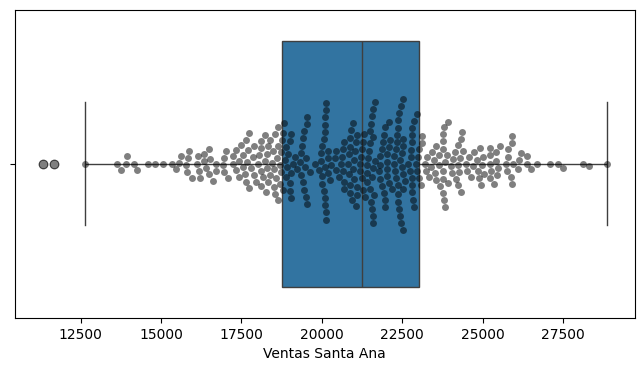

In [106]:
# Análisis de valores atípicos y distribuciones de las ventas del supermercado Santa Ana
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Ventas Santa Ana", data=data_combined, ax=ax)
sns.swarmplot(x="Ventas Santa Ana", data=data_combined, color='black', alpha = 0.5, ax=ax);

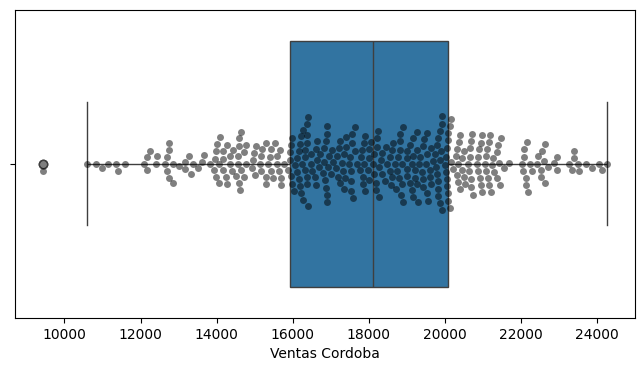

In [107]:
# Análisis de valores atípicos y distribuciones de las ventas del supermercado Ventas Cordoba
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Ventas Cordoba", data=data_combined, ax=ax)
sns.swarmplot(x="Ventas Cordoba", data=data_combined, color='black', alpha = 0.5, ax=ax);

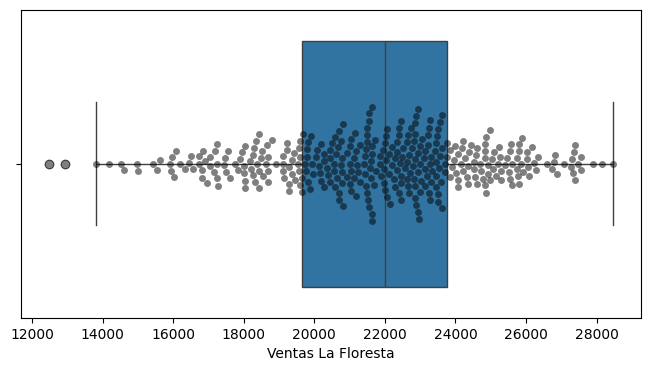

In [108]:
# Análisis de valores atípicos y distribuciones de las ventas del supermercado Ventas La Floresta
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Ventas La Floresta", data=data_combined, ax=ax)
sns.swarmplot(x="Ventas La Floresta", data=data_combined, color='black', alpha = 0.5, ax=ax);

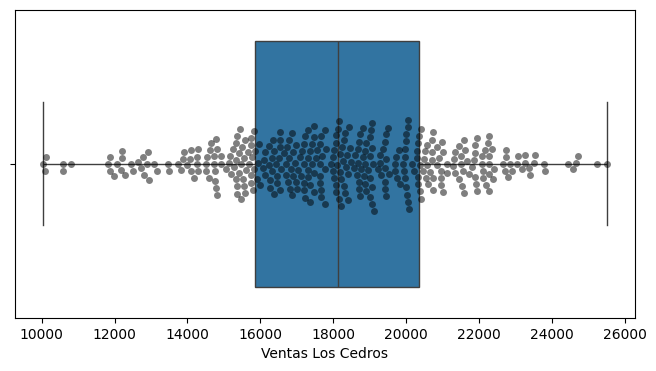

In [109]:
# Análisis de valores atípicos y distribuciones de las ventas del supermercado Ventas Los Cedros
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Ventas Los Cedros", data=data_combined, ax=ax)
sns.swarmplot(x="Ventas Los Cedros", data=data_combined, color='black', alpha = 0.5, ax=ax);

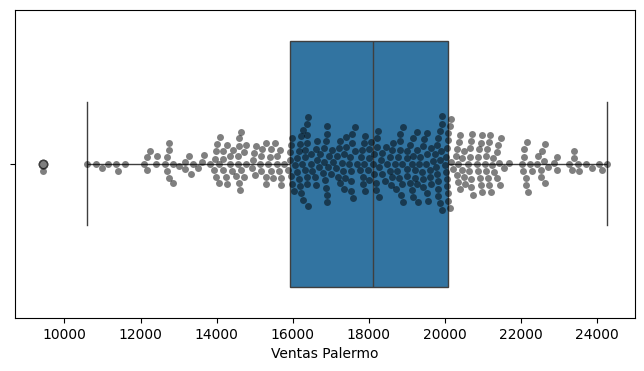

In [110]:
# Análisis de valores atípicos y distribuciones de las ventas del supermercado Ventas Palermo
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="Ventas Palermo", data=data_combined, ax=ax)
sns.swarmplot(x="Ventas Palermo", data=data_combined, color='black', alpha = 0.5, ax=ax);

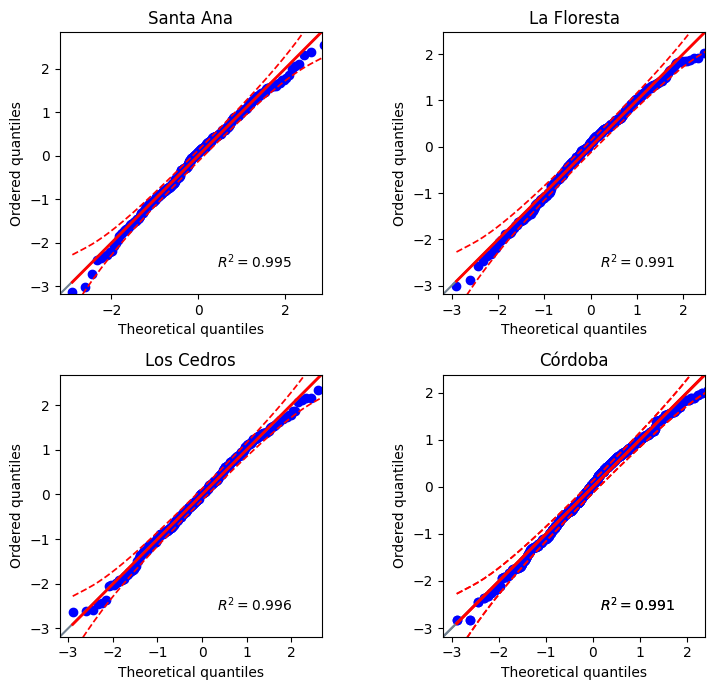

In [111]:
# Gráficos qqplot
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
pg.qqplot(data_combined["Ventas Santa Ana"], dist='norm', ax=axs[0,0])
axs[0,0].set_title('Santa Ana')
pg.qqplot(data_combined["Ventas La Floresta"], dist='norm', ax=axs[0,1])
axs[0,1].set_title('La Floresta')
pg.qqplot(data_combined['Ventas Los Cedros'], dist='norm', ax=axs[1,0])
axs[1,0].set_title('Los Cedros')
pg.qqplot(data_combined['Ventas Palermo'], dist='norm', ax=axs[1,1])
axs[1,1].set_title('Palermo')
pg.qqplot(data_combined["Ventas Cordoba"], dist='norm', ax=axs[1,1])
axs[1,1].set_title('Córdoba')
plt.tight_layout()

## Desarrollo de preguntas

####1. Determinen intervalos de confianza empı́ricos para el supermercado ’Santa Ana’ en cada mes, para significancias del 95 % y el 99 %.

In [112]:
# Supermercado Santa Ana
df_santa_ana = pd.read_csv("/content/drive/MyDrive/examen-final-PEIA/Datos_examen_final_17Co2024_Grupo9.xlsx - Santa Ana.csv")
df_santa_ana["Fecha"] = pd.to_datetime(df_santa_ana["Fecha"])
df_santa_ana.set_index("Fecha", inplace=True)
print("Cantidad total de registros:",len(df_santa_ana))
df_santa_ana.head()

Cantidad total de registros: 365


,Ventas
Fecha,
2023-01-01,13915.65363
2023-01-02,16713.74951
2023-01-03,17415.85259
2023-01-04,19494.02393
2023-01-05,22818.79946


,month,mean,std_dev,95%,99.7%
0,January,17080.033021,2691.991701,"(11696.049618889587, 22464.016423691064)","(9004.057917689217, 25156.008124891432)"
1,February,19161.388438,3370.833041,"(12419.722354589092, 25903.05452041091)","(9048.889313133635, 29273.887561866366)"
2,March,21986.340047,2631.834274,"(16722.67149790814, 27250.00859564023)","(14090.837223475119, 29881.84287007325)"
3,April,20059.823372,2543.818975,"(14972.185421952898, 25147.4613220471)","(12428.366446929349, 27691.280297070647)"
4,May,21220.437810,2385.686775,"(16449.064260012776, 25991.811359342064)","(14063.377485180452, 28377.498134174388)"
5,June,22295.229575,2585.169159,"(17124.891257859104, 27465.567892140898)","(14539.722099288654, 30050.73705071135)"
6,July,20858.711828,2624.624809,"(15609.462210415935, 26107.961446358262)","(12984.837401430355, 28732.586255343842)"
7,August,21951.956076,2809.589937,"(16332.77620214385, 27571.13595011421)","(13523.18626515126, 30380.7258871068)"
8,September,22908.471373,2727.945127,"(17452.581118966584, 28364.361627033424)","(14724.635991949872, 31092.306754050136)"
9,October,22174.217918,2623.927731,"(16926.36245626671, 27422.073379862326)","(14302.434725367802, 30046.001110761234)"


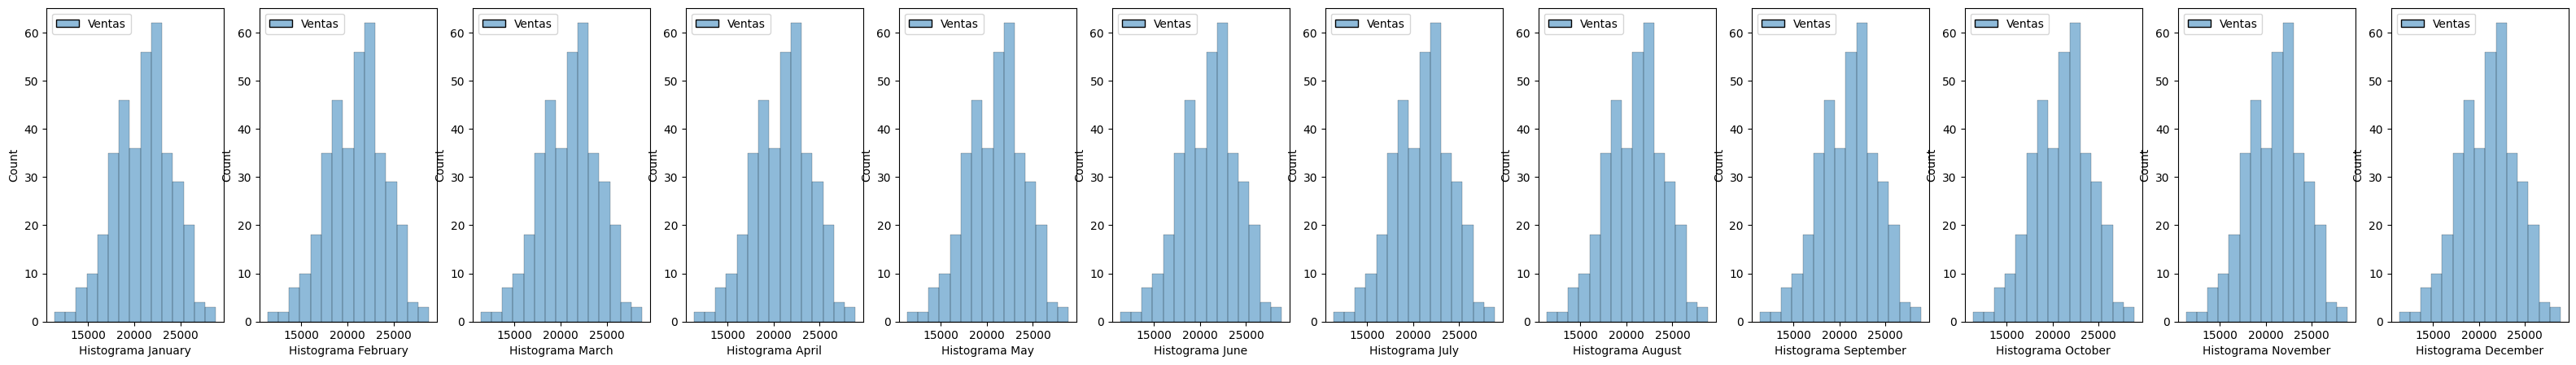

In [113]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

NUMBER_OF_MONTHS = 12

ci_empiric = {
    "month": [],
    "mean": [],
    "std_dev": [],
    "95%": [],
    "99.7%": []
}

df_santa_ana_by_month = []

fig, axs = plt.subplots(nrows=1, ncols=NUMBER_OF_MONTHS)
for i in range(NUMBER_OF_MONTHS):
    month_data = df_santa_ana["Ventas"].iloc[df_santa_ana.index.month == i+1]
    ci_empiric["month"].append(calendar.month_name[i+1])
    month_mean = month_data.mean()
    month_std = month_data.std()
    ci_empiric["mean"].append(month_mean)
    ci_empiric["std_dev"].append(month_std)
    ci_empiric["95%"].append((month_mean - 2*month_std, month_mean + 2*month_std))
    ci_empiric["99.7%"].append((month_mean - 3*month_std, month_mean + 3*month_std))
    sns.histplot(data=df_santa_ana, ax=axs[i])
    axs[i].set_xlabel("Histograma " + calendar.month_name[i+1])
    df_santa_ana_by_month.append(month_data)

ci_empiric_df_santa_ana = pd.DataFrame.from_dict(ci_empiric)
display(ci_empiric_df_santa_ana)
fig.set_size_inches(40, 5)

####2. Realicen pruebas ANOVA para determinar si las ventas esperadas de todas las tiendas son iguales o no,con significancia del 95

* Hipótesis nula (H₀): Las medias de ventas de todas las tiendas son iguales.
* Hipótesis alternativa (H₁): Al menos una media de ventas es diferente.
* Utilizaremos un nivel de significancia del 5% (α = 0.05), que corresponde al 95% de confianza.

In [114]:
import pandas as pd
import scipy.stats as stats

# Extraer los datos de ventas de cada supermercado
ventas_santa_ana = data_combined['Ventas Santa Ana']
ventas_cordoba = data_combined['Ventas Cordoba']
ventas_la_floresta = data_combined['Ventas La Floresta']
ventas_los_cedros = data_combined['Ventas Los Cedros']
ventas_palermo = data_combined['Ventas Palermo']

# Aplicar ANOVA de una vía para comparar las ventas entre los supermercados
f_valor, p_valor = stats.f_oneway(ventas_santa_ana, ventas_cordoba, ventas_la_floresta, ventas_los_cedros, ventas_palermo)

print(f"F-valor: {f_valor}")
print(f"P-valor: {p_valor}")

F-valor: 139.5436709828261
P-valor: 4.118560544003113e-104


####3. Identifiquen la tienda con mayor promedio de ventas y la tienda con menor promedio de ventas y realicen
una prueba de hipótesis para determinar si la diferencia entre ellas es distinta de cero o no.

In [116]:
import numpy as np
from scipy import stats

mean_sales = data_combined.mean()
max_sales = mean_sales.idxmax()
min_sales = mean_sales.idxmin()
print("Max. sales:", max_sales)
print("Min. sales:", min_sales)

max_min_mean_sales = np.concatenate((data_combined[max_sales].to_numpy(), data_combined[min_sales].to_numpy()))

res = stats.ttest_1samp(max_min_mean_sales, data_combined.mean(axis=None))
print(res)
print("La media de las muestras se desvía",  res.statistic, "de la hipotesis nula.")

Max. sales: Ventas La Floresta
Min. sales: Ventas Cordoba
TtestResult(statistic=3.719689748686689, pvalue=0.0002147921194865622, df=729)
La media de las muestras se desvía 3.719689748686689 de la hipotesis nula.


####4. Determinen la distribución a posteriori del parámetro p de porcentaje de morosidad. Determinar su media y su varianza.

## Bibliografía


https://cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python